# Recepit Count Forecasting Model

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
plt.rcParams['figure.figsize'] = (8, 6)

In [18]:
print(1)

1


#### Read in Data


In [19]:
df = pd.read_csv("data/data_daily.csv")
print(f"The dataset has {df.shape[0]} records, and {df.shape[1]} features.")

The dataset has 365 records, and 2 features.


# Feature Selection 
Let's check the datatypes of our features


In [20]:
df.dtypes

# Date           object
Receipt_Count     int64
dtype: object

We see that the Date is currently of type object, so let's convert it to a Datatime object which will be helpful in the upcoming steps.

In [21]:
# remove the # from the column name
df.rename(columns={'# Date': 'Date'}, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)


Let's extract some granular information from the date object in order to better understand patterns in our data:
- **Day (`day`)**
  
- **Month (`month`)**
   
- **Year (`year`)**
   
- **Weekday (`weekday`)**
   
- **Is Weekend (`is_weekend`)**
  
- **Quarter (`quarter`)**

- **Day of the Year (`day_of_year`)**
  

  
*Also, let's convert these to `np.float64`*

In [22]:
df["day"] = df.index.day.astype(np.float64)
df["month"] = df.index.month.astype(np.float64)
df["year"] = df.index.year.astype(np.float64)
df["weekday"] = df.index.weekday.astype(np.float64)
df["is_weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0).astype(np.float64)
df["quarter"] = df.index.quarter.astype(np.float64)
df["day_of_week"] = df.index.dayofweek.astype(np.float64)
df["day_of_year"] = df.index.dayofyear.astype(np.float64)
df.Receipt_Count = df.Receipt_Count.astype(np.float64)            

This is what the data types look like now

In [23]:
df.dtypes

Receipt_Count    float64
day              float64
month            float64
year             float64
weekday          float64
is_weekend       float64
quarter          float64
day_of_week      float64
day_of_year      float64
dtype: object

In [24]:
df.head()

,Receipt_Count,day,month,year,weekday,is_weekend,quarter,day_of_week,day_of_year
Date,,,,,,,,,
2021-01-01,7564766.0,1.0,1.0,2021.0,4.0,0.0,1.0,4.0,1.0
2021-01-02,7455524.0,2.0,1.0,2021.0,5.0,1.0,1.0,5.0,2.0
2021-01-03,7095414.0,3.0,1.0,2021.0,6.0,1.0,1.0,6.0,3.0
2021-01-04,7666163.0,4.0,1.0,2021.0,0.0,0.0,1.0,0.0,4.0
2021-01-05,7771289.0,5.0,1.0,2021.0,1.0,0.0,1.0,1.0,5.0


### Visualize Data
Let us first plot the graph of each independent variable against the target variable (`Receipt_Count`).

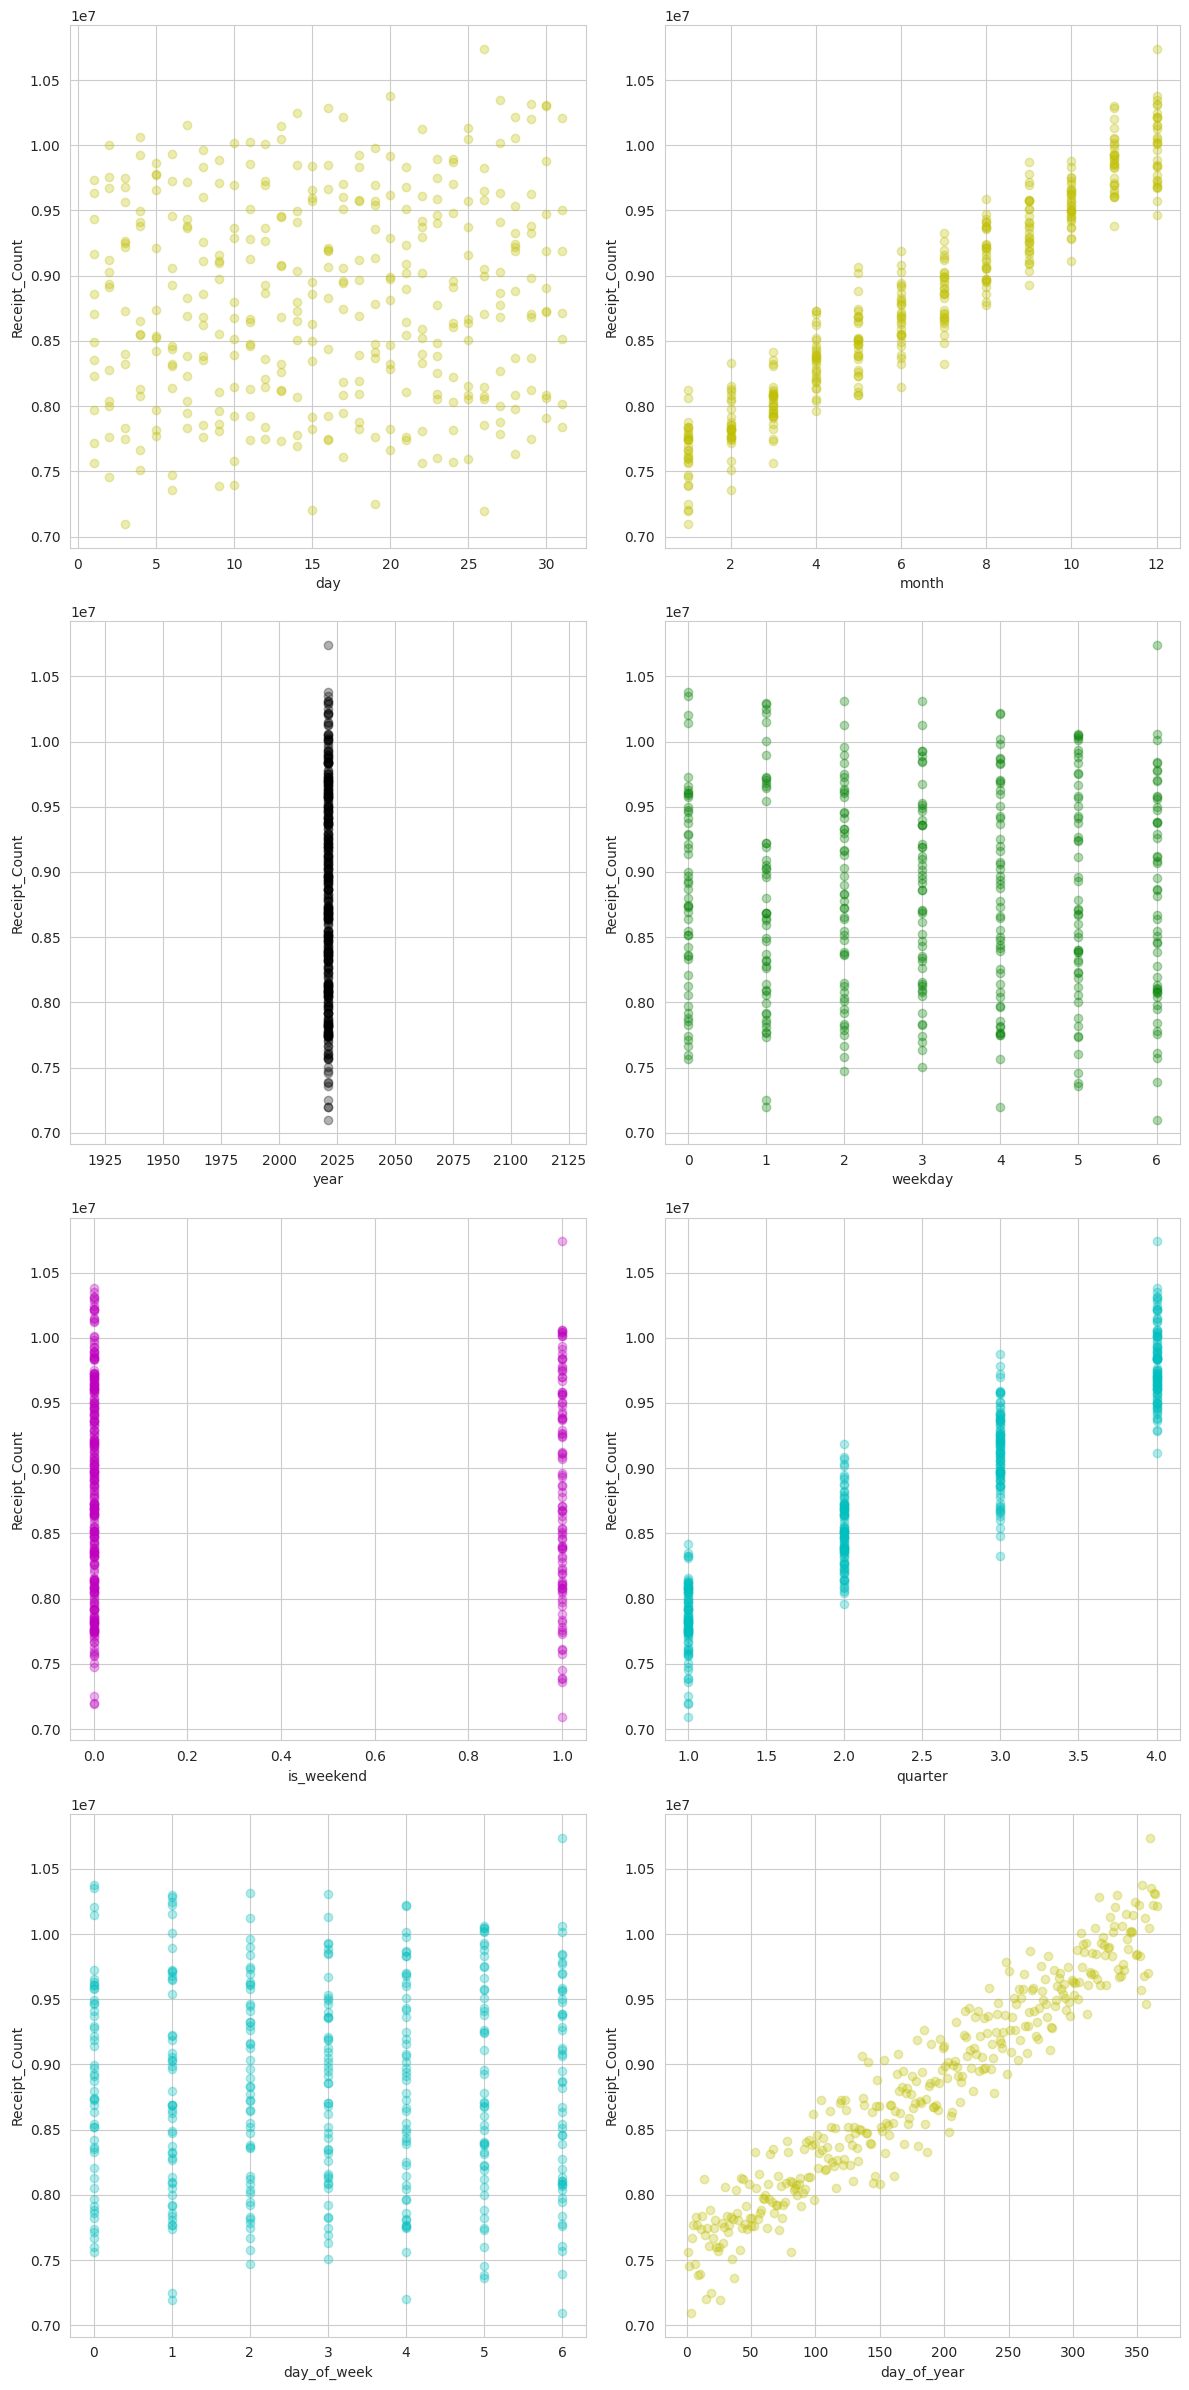

In [25]:
# Function for plotting independent variables against target variable
# fig, a =  plt.subplots(3, figsize = (5, 5*3))
def plotter(column_list, target_col, df):
    """Plots scatterplot for each independent variable against the target variable
    
    Args-
        column_list- List containing names of all the dependent variables
        target_col- Name of the target variable
        df- The dataframe
    Returns-
        None
    """
    n = len(column_list)
    color = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] # list of color values
    
    # Calculate number of rows based on the number of plots. Using ceil for odd numbers.
    rows = int(np.ceil(n/2.0))
    
    fig, axes = plt.subplots(rows, 2, figsize=(12, 6*rows))
    
    # Flattening the 2D array of axes
    flat_axes = axes.ravel()
    
    for i, col in enumerate(column_list):
        ax = flat_axes[i]
        ax.scatter(df[col], df[target_col], alpha=0.3, c=np.random.choice(color))
        ax.set_xlabel(col)
        ax.set_ylabel(target_col)
        
        # If n is odd, remove the last (unused) subplot
        if n%2 != 0 and i == len(column_list) - 1:
            fig.delaxes(flat_axes[-1])
    
    plt.tight_layout()
    plt.show()


# creates a list of all the columns except the target column
cols_list = list(df.columns)
cols_list.remove('Receipt_Count')

# Target variable holds the name of the target variable
target_col = 'Receipt_Count'

plotter(cols_list, target_col, df)

It looks like the `year` column is not providing any variance to the data. Let's drop it.

In [26]:
df.drop(columns=["year"], inplace=True)

Now, let us have a look at the correlation values for our dataset.

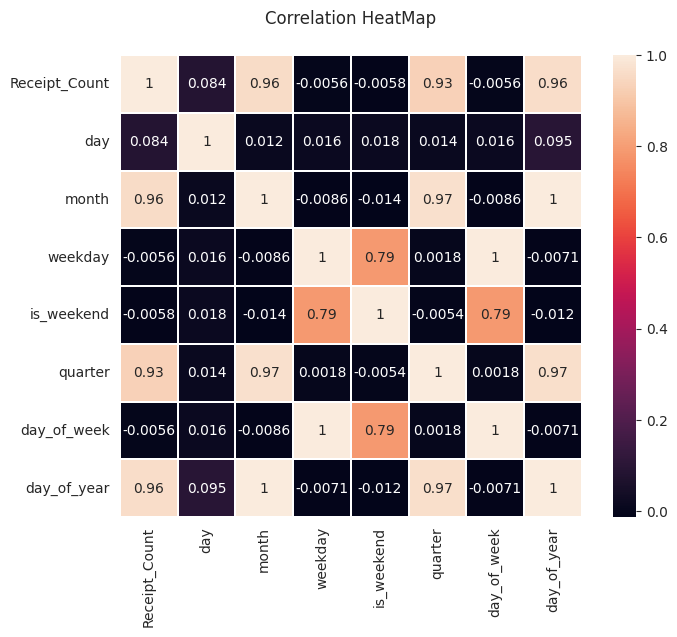

In [31]:
# plots a correlation heatmap

plt.title('Correlation HeatMap', y = 1.05)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)
plt.show()

From the above visual analysis, we can see that **day_of_year** (++0.96), **quarter** (+0.93) and **month** (+0.96) show a very strong correlation with the dependent variable, **Receipt_Count**.

However, **month** and **quarter** show a strong correlation  between themselves as well. Such Multi Collinearilty could create an overfitting scenario if we are to go ahead and build a simple Regression Model

# Feature Engineering

In [28]:
df.Receipt_Count.min()

7095414.0

#### Scale Dependent Variable, `Receipt_Count`
Let's first visualize the distribution 

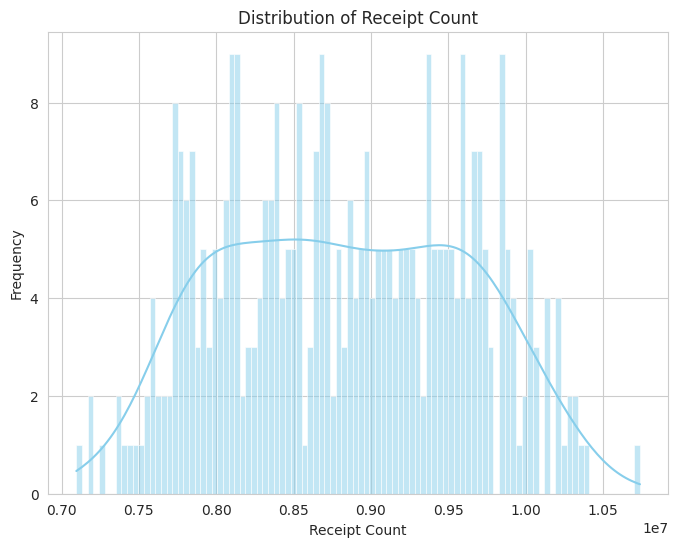

In [32]:
sns.set_style('whitegrid')
sns.histplot(df.Receipt_Count, bins=100, color='skyblue', kde=True)
plt.title('Distribution of Receipt Count')
plt.xlabel('Receipt Count')
plt.ylabel('Frequency')
plt.show()


In the data we have, the Receipt_Count Column has values in the magnitude of millions. With the largest count for a day being 10738865 and the smallest count for a day being 7095414. This will get even greater when we try to make forecasts for months in the following year. Ideally for building a model, it is better if the data is in a smaller range. Let's explore some possible options to scale the data. 

##### Min-Max Scaling
This method can be used to scale data between 0 and 1, however, there are certain outliers in the data. Hence this method will not be very effective here

##### Standard Scaling (Z-score)
This method centers the data around 0 and scales based on the standard deviation. It's less sensitive to small standard deviations than Min-Max scaling and is less affected by outliers. However, this method is good if the data follows a Gaussian Distribution. 

Looking at the Distribution plot above, it does not look like the data follows a Gaussian Distribution. 

To further verify, let's runa  statistical test with a null hypothesis that the data is drawn from a normal distribution.. If we get a p-value greater than 0.05, we can conduct some further analysis on the assumption that it comes froma  Gaussian Distribution. 

In [33]:
stat, p = shapiro(df.Receipt_Count)
print(f"P-value: {p}")
if p > 0.05:
    print('Sample looks Gaussian')
else:
    print('Sample does not look Gaussian')

P-value: 1.4178785022522788e-05
Sample does not look Gaussian


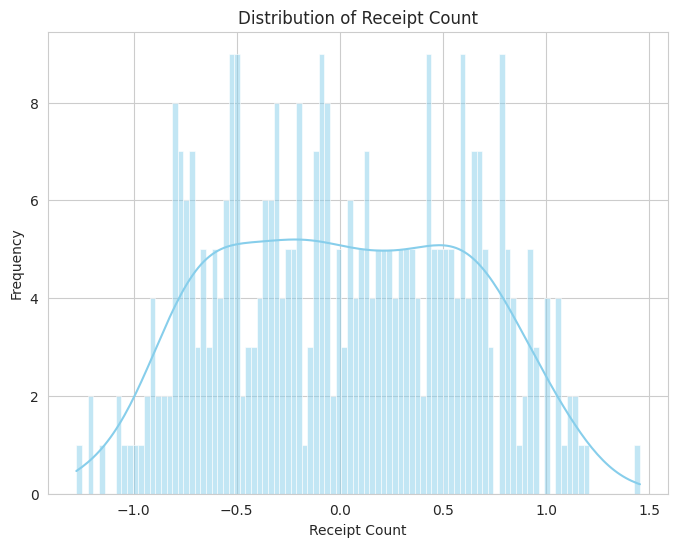

In [34]:
def robust_scaler(data):
    """
    Scales the given data using the interquartile range.
    
    Args:
    - data (list or numpy array): The input data to be scaled.
    
    Returns:
    - numpy array: The robustly scaled data.
    """
    # Convert the input data to numpy array for computation
    data = np.array(data)
    
    # Calculate the first (25th percentile) and third quartile (75th percentile)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate the interquartile range
    IQR = Q3 - Q1
    
    # Calculate the median
    median = np.median(data)
    
    # Scale the data
    scaled_data = (data - median) / IQR
    
    return scaled_data



sns.set_style('whitegrid')
sns.histplot(robust_scaler(df.Receipt_Count), bins=100, color='skyblue', kde=True)
plt.title('Distribution of Receipt Count')
plt.xlabel('Receipt Count')
plt.ylabel('Frequency')
plt.show()

#### Scale Independent Variables